In [5]:
import time

import pandas as pd # used to load the data
import numpy as np # optimized numerical library

from sklearn import preprocessing, metrics, utils, decomposition, model_selection, linear_model, discriminant_analysis, svm, tree, ensemble # library providing several ML algorithms and related utility
from sklearn.neural_network import MLPClassifier

from imblearn import over_sampling # provides several resampling techniques to cope with unbalanced datasets (https://github.com/scikit-learn-contrib/imbalanced-learn) compatible with sklearn

from collections import Counter

import matplotlib.pyplot as plt # used for plotting

# Start by defining three helper functions:
# - one to plot the sample distribution  acorss the class labels (to see how un-/balanced the dataset is)
# - one to compute and plot the confusion matrix
# - one to plot data in 2D with different colors per class label

def plot_pie(y, labels, title=""):
    target_stats = Counter(y)
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.set_title(title + " (size: %d)" % len(y))
    ax.pie(sizes, explode=explode, labels=target_stats.keys(), shadow=True, autopct='%1.1f%%')
    ax.axis('equal')


def compute_and_plot_cm(ytest, ypred, labels, title=""):
    global nfigure
    # Compute confusion matrix
    cm = metrics.confusion_matrix(ytest, ypred)
    
    accuracy = metrics.accuracy_score(ytest, ypred, normalize=True)

    # Normalize the matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    # Plot the confusion matrix

    nfigure = nfigure + 1
    plt.figure(nfigure) # new numbered figure
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # plot the confusionmatrix using blue shaded colors
    plt.title("Confusion Matrix Normalized (%s) Accuracy: %.1f%%" % (title, accuracy*100)) # add title
    plt.colorbar() # plot the color bar as legend

    # Plot the x and y ticks using the class label names
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)


def plot_2d(xpred, ypred, labels, title=""):
    global nfigure
    # define the colors to use for each class label
    colors = ['red', 'blue', 'green', 'yellow', 'black']
    len_colors = len(colors)
    if len_colors < len(labels):
        print("WARNING: we have less colors than classes: some classes will reuse the same color")

    nfigure = nfigure + 1
    plt.figure(nfigure) # new numbered figure
    plt.title("Feature Space (%s)" % title) # add title


    # plot each class label with a separate color 
    for c in range(len(labels)):
        cur_class = (ypred == c) # get all points belonging to class c
        plt.plot(xpred[cur_class, 0], xpred[cur_class, 1], 'o', color=colors[c % len_colors]) # plot class c


nfigure = 0 #used to number the figures

# 1. Loading the data

In [6]:
################ Load data ####################
# Get the dataset loaded and split it in training and target
df_train = pd.read_csv("data_m.csv")
df_train = df_train.apply(preprocessing.LabelEncoder().fit_transform)

# re-order them
df_train = df_train[
    [
        'model', 'Cores', 'GBRAM', 'batchSize', 'learningRate', 
        'learningRateDecay', 'accuracy', 'responsetime', 'status'
    ]
]

train_x = df_train.iloc[:,0:6] # features (ignore accuracy and responsetime)
train_y = df_train.iloc[:,8]  # target

# Get the dataset loaded and split it in testing and target
df_test = pd.read_csv("test/data__m_test.csv") 
df_test = df_test.apply(preprocessing.LabelEncoder().fit_transform)

# re-order them
df_test = df_test[
    [
        'model', 'Cores', 'GBRAM', 'batchSize', 'learningRate', 
        'learningRateDecay', 'status'
    ]
]

test_x = df_test.iloc[:,0:6] # features
test_y = df_test.iloc[:,6]  # target

df_train

,model,Cores,GBRAM,batchSize,learningRate,learningRateDecay,accuracy,responsetime,status
0,0,1,1,1,1,1,88,49,0
1,0,0,1,1,1,1,123,141,1
2,0,1,0,1,1,1,129,53,0
3,0,0,0,1,1,1,95,138,1
4,0,1,1,0,1,1,111,101,1
...,...,...,...,...,...,...,...,...,...
187,1,0,0,1,0,0,107,80,1
188,1,1,1,0,0,0,72,25,0
189,1,0,1,0,0,0,76,92,1
190,1,1,0,0,0,0,86,34,0


### Lets make the data balance: over_sampling.SMOTE

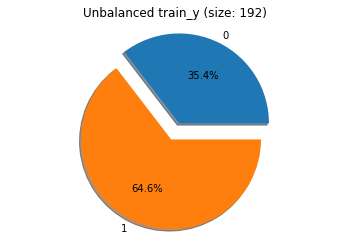

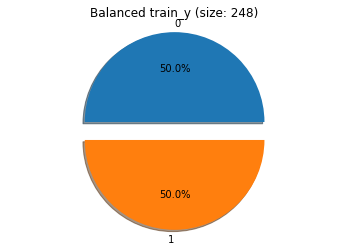

In [7]:
################ Resample data #################
data_class_labels = np.unique(train_y)
plot_pie(train_y, data_class_labels, "Unbalanced train_y")

# If the data is very skewed, try to balance the dataset
sm = over_sampling.SMOTE(random_state=42)
train_x, train_y = sm.fit_sample(train_x, train_y)

# Plot the balanced label distribution
plot_pie(train_y, data_class_labels, "Balanced train_y")

# 2. Preparing the data

In [8]:
################ Scale data ####################
# Train a scaler to standardize the features (zero mean and unit variance)

# Compute the mean and std to be user for later scaling
scaler = preprocessing.StandardScaler()

# ... and scale the features
# Perform standardization by centering and scaling
X_train_scaled = scaler.fit_transform(train_x)
X_test_scaled = scaler.fit_transform(test_x)

# 4. Apply Decision Tree

0.8


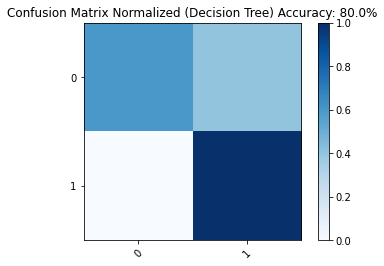

In [52]:
################ DecisionTree ##################
# Train a DT model on the original features
dt = tree.DecisionTreeClassifier(max_depth=5).fit(train_x, train_y)

# Compute the predicted labels on test data
y_dt = dt.predict(test_x)

# print the accuracy
score = metrics.accuracy_score(test_y, y_dt)
print(score)

# Compute and show confusion matrix
compute_and_plot_cm(test_y, y_dt, data_class_labels, title="Decision Tree")

# 3. Logistic Regression

Acuracy of LR : 80.0%


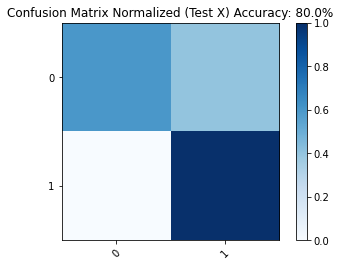

In [10]:
################ Logit ##################
# Train a Logit model on the original features
lr = linear_model.LogisticRegression().fit(train_x, train_y)
data_class_labels = np.unique(train_y)

# Compute the predicted labels on test data
y_lr = lr.predict(test_x)

# Prit the accuracy
print("Acuracy of LR : %.1f%%" % (metrics.accuracy_score(y_lr, test_y)*100))

# Compute and print and confusion matrix
compute_and_plot_cm(test_y, y_lr, data_class_labels, title="Test X")

# 4. Recommendation

In [87]:
def recommend(df, model_selected):    
    df = df.sort_values(by=['accuracy', 'responsetime'], ascending=(False, False))

    row = df[df.model == model_selected].iloc[0]
    # Get array of system-, and hyper-parameters that gives the best performance
    # In other words, recommend this to the user
    model = row.values[0]
    cores = row.values[1]
    ram = row.values[2]
    batch_size = row.values[3]
    learning_rate = row.values[4]
    learning_rate_decay = row.values[5]

    print('Better: {}-model {}-Cores {}-GBRAM {}-batchSize {}-learningRate {}-learningRateDecay'.format(
        model, cores, ram, batch_size, learning_rate, learning_rate_decay
    ))
    
    return cores, ram, batch_size, learning_rate, learning_rate_decay, model

In [88]:
############################
# Simulate a job coming in #
############################
request = {
    'model': ['lenet5'], 
    'Cores': [1], # 1 or 4
    'GBRAM': [1], # 1 or 8 
    'batchSize': [64], # 64 or 512
    'learningRate': [0.001], # 0.1 or 0.001
    'learningRateDecay': [0.001], # 0.001 or 0.0001
    'status': ['slow'] # This is not needed but it's for removing the error
}

job = pd.DataFrame.from_dict(request)

##################################################################################
# load the dataset, append incoming job, train and classify if job can be better #
##################################################################################
df = pd.read_csv("data_m.csv")
df_train = df
df_train = df_train.append(job, sort=False)

df_train = df_train.apply(preprocessing.LabelEncoder().fit_transform)
df_train = df_train[
    [
        'model', 'Cores', 'GBRAM', 'batchSize', 'learningRate', 
        'learningRateDecay', 'accuracy', 'responsetime', 'status'
    ]
]
df_train = df_train[:-1] # Since the incoming job is now encoded, we can remove it

train_x = df_train.iloc[:,0:6] # features (ignore accuracy and responsetime)
train_y = df_train.iloc[:,8]  # target_dict(request)

# # Train a DT model on the original features
dt = tree.DecisionTreeClassifier(max_depth=5).fit(train_x, train_y)

# Compute the predicted labels on test data
predicted_output = dt.predict(train_x.iloc[[-1], [0, 1, 2, 3, 4, 5]])[0]
if predicted_output: # 1, means it's slow and needs fixing
    recommend(df, request['model'][0])
else: # Already good, not need to fix it
    pass

      model  Cores  GBRAM  batchSize  learningRate  learningRateDecay  status  \
183  lenet5      1      1         64         0.100             0.0001  normal   
150  lenet5      4      1         64         0.100             0.0001    slow   
146  lenet5      4      1        512         0.100             0.0001  normal   
161  lenet5      1      8        512         0.100             0.0010    slow   
119  lenet5      1      1         64         0.100             0.0001    slow   
..      ...    ...    ...        ...           ...                ...     ...   
73   bi-rnn      1      8        512         0.001             0.0010    slow   
90   bi-rnn      4      1        512         0.001             0.0001    slow   
86   bi-rnn      4      1         64         0.100             0.0001  normal   
143  lenet5      1      1         64         0.001             0.0010  normal   
162  lenet5      4      1        512         0.100             0.0010  normal   

     accuracy  responsetime